<a href="https://colab.research.google.com/github/cjfghk5697/AjouDeeplearning_Compete/blob/main/%EC%B6%94%EC%A0%81%EA%B7%B8%EB%9E%98%ED%94%84%20%EC%B6%94%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 이진화 코드 추가
 이진화란 이미지를 흰색과 검은색으로 바꾼다고 생각하면 된다.
속도가 향상되고 정확도도 미약하지만 향상된것을 볼수 있다.

 [Dacon 적용 예시](https://dacon.io/competitions/official/235697/codeshare/2436?page=2&dtype=recent)


 [이진화 설명](https://gmnam.tistory.com/263)

 <hr>

 # 2. train, valid set 나누기
```
train_dataset, valid_dataset = torch.utils.data.random_split(trainset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=64, num_workers=8)
```
처음에는 나누어지지 않아있는 코드였단 걸 발견하고 random_split 함수를 이용해 나눔. 그리고 학습 부분에서 valid 데이터를 enumerate하는 구문추가해서 valid 확인.

<hr>

# 3. Multi Sample Dropout 구현

[자료](https://velog.io/@sujeongim/%EC%83%88%EB%A1%9C-%EB%B0%B0%EC%9A%B4-%EC%BD%94%EB%93%9C-%EC%A1%B0%EA%B0%81-Multi-Sample-Dropout)
단순 dropout 기법을 안썼다. 근데 큰효과가 있는지는 잘 모르지만 overfitting의 위협도 없앨겸 선택했다.

<hr>

# 4. Scheduler 추가
일단 간단하게 StepLR scheduler을 추가했다.



<hr>

# 5. Drop out 실수
전 Drop out에서는 sigmoid가 있다. 근데 필자가 Multi-Label Loss Function을 이용함으로써 활성화 함수를 더 추가할 필요가 없었다. 그러나 sigmoid를 또 넣음으로써 sigmoid 계층 2개를 들어가는 거다. 결국 loss 값이 적어져서 학습 진행이 안된거다. 학습이 잘 안되면 활성화 함수에서 loss 값이 얼마 나오는지 잘 확인해야겠다..

https://cvml.tistory.com/26 
Multi-Label Loss Function에 대해 잘 설명 되어있다.


<hr>

# 6. 왜 정확도가 안오를까?
이상하게도 valid도 장확도가 같이 오르는데 test를 하면 정확도는 50%다 혹시나 해서 이진화를 빼고 해봤는데도 정확도가 안오른다 (05.15)

-테스트

1. efficientnetb1에서 epoch 수를 늘려봤다. 과거에는 5번 정도만 해도 valid 정확도가 높게 나왔다. 하지만 epoch를 늘린다고 해결될 일이 절대 아닌 거 같다.

2. overfitting 인거 같아서 dropout을 추가했다. 활성화 함수도 한층 추가해봐서 실험.




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#%cd /content/drive/MyDrive/Train image2
#!unzip -q "/content/drive/MyDrive/multi-mnist zipfile/dirty_mnist_2nd.zip"

In [3]:
!pip3 install torchinfo
!pip3 install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [4]:
import os
from typing import Tuple, Sequence, Callable
import csv
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.optim as optim
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import transforms
from torchvision.models import efficientnet_b0
from torch.nn import functional as F

In [5]:
class MnistDataset(Dataset):
    def __init__(
        self,
        dir: os.PathLike,
        image_ids: os.PathLike,
        transforms: Sequence[Callable]
    ) -> None:
        self.dir = dir
        self.transforms = transforms

        self.labels = {}
        with open(image_ids, 'r') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                self.labels[int(row[0])] = list(map(int, row[1:]))

        self.image_ids = list(self.labels.keys())

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, index: int) -> Tuple[Tensor]:
        image_id = self.image_ids[index]
        image = Image.open(
            os.path.join(
                self.dir, f'{str(image_id).zfill(5)}.png')).convert('RGB')
        target = np.array(self.labels.get(image_id)).astype(np.float32)


        image = np.array(image)
#이진화 완료 cv2 툴을 써서 threshold로 254 값으로 변환. cv2는 넘파이만 사용 가능해서 넘파이로 변환후 fromarry로 pil로 바꾼다.
        image_th = cv2.threshold(image,254,255,0)[1]
        image_th = Image.fromarray(image_th) # NumPy array to PIL image
        if self.transforms is not None:
            image = self.transforms(image_th)

        return image, target

In [6]:
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])



In [7]:
trainset = MnistDataset('/content/drive/MyDrive/Train image2', '/content/drive/MyDrive/multi-mnist zipfile/dirty_mnist_2nd_answer.csv', transforms_train)

train_size = int(0.8 * len(trainset))
valid_size = len(trainset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(trainset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, num_workers=4)


In [8]:
class MnistModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = efficientnet_b0(pretrained=True)
        self.dropout=nn.Dropout(p=0.5)
        self.classifier = nn.Linear(1000, 26)
    def forward(self, x):
        x = F.relu(self.model(x))
 #       x = self.model(x)
        x = self.dropout(x)
  
        x = self.classifier(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MnistModel().to(device)
print(summary(model, input_size=(1, 3, 256, 256), verbose=0))

Layer (type:depth-idx)                                       Output Shape              Param #
MnistModel                                                   --                        --
├─EfficientNet: 1-1                                          [1, 1000]                 --
│    └─Sequential: 2-1                                       [1, 1280, 8, 8]           --
│    │    └─ConvNormActivation: 3-1                          [1, 32, 128, 128]         928
│    │    └─Sequential: 3-2                                  [1, 16, 128, 128]         1,448
│    │    └─Sequential: 3-3                                  [1, 24, 64, 64]           16,714
│    │    └─Sequential: 3-4                                  [1, 40, 32, 32]           46,640
│    │    └─Sequential: 3-5                                  [1, 80, 16, 16]           242,930
│    │    └─Sequential: 3-6                                  [1, 112, 16, 16]          543,148
│    │    └─Sequential: 3-7                                  [1, 192, 8, 

In [9]:

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MultiLabelSoftMarginLoss()
    #scheduler 추가 및 step 추가
path = "/content/drive/MyDrive/models/"
MODEL = "efficientnet5"

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)   
num_epochs = 15
model.train()

for epoch in range(num_epochs):
    train_acc_list = []
    valid_acc_list =[]
    for i, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            outputs = outputs > 0.5
            acc = (outputs == targets).cpu().float().mean()
            train_acc_list.append(acc)

            print(f'{epoch}: "train loss:"{loss.item():.5f}, "train acc: "{acc.item():.5f}')
    for i, (images, targets) in enumerate(valid_loader):
        optimizer.zero_grad()

        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        valid_loss = criterion(outputs, targets)
      
        if (i+1) % 10 == 0:
            outputs = outputs > 0.5
            valid_acc = (outputs == targets).cpu().float().mean()
            valid_acc_list.append(valid_acc)

            print(f'{epoch}: "val loss:"{valid_loss.item():.5f}, "val acc: "{valid_acc.item():.5f}')
    lr_scheduler.step()
    torch.save(model.state_dict(), f'{path}_{MODEL}_1.pth')

0: "train loss:"0.70355, "train acc: "0.54327
0: "train loss:"0.69599, "train acc: "0.52524
0: "train loss:"0.68894, "train acc: "0.54688
0: "train loss:"0.69335, "train acc: "0.53846
0: "train loss:"0.69721, "train acc: "0.52224
0: "train loss:"0.69366, "train acc: "0.53666
0: "train loss:"0.68803, "train acc: "0.54267
0: "train loss:"0.69577, "train acc: "0.53065
0: "train loss:"0.68388, "train acc: "0.53966
0: "train loss:"0.69061, "train acc: "0.53726
0: "train loss:"0.68829, "train acc: "0.53546
0: "train loss:"0.68710, "train acc: "0.53185
0: "train loss:"0.68426, "train acc: "0.54988
0: "train loss:"0.68470, "train acc: "0.54207
0: "train loss:"0.69191, "train acc: "0.53425
0: "train loss:"0.68609, "train acc: "0.53365
0: "train loss:"0.67517, "train acc: "0.55168
0: "train loss:"0.67421, "train acc: "0.54207
0: "train loss:"0.68259, "train acc: "0.54026
0: "train loss:"0.67843, "train acc: "0.54147
0: "train loss:"0.68528, "train acc: "0.54507
0: "train loss:"0.68212, "train ac

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


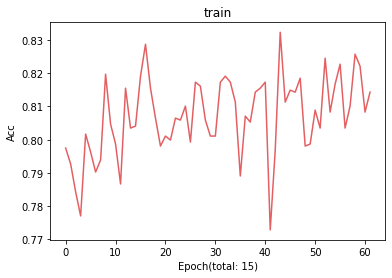

In [25]:
import matplotlib.pyplot as plt

a = [ i for i in range(num_epochs)]
print(a)

plt.plot(train_acc_list, color='#e35f62', label='Train Acc')
#plt.plot(valid_acc_list, color='forestgreen', label='Valid Acc')
plt.xlabel('Epoch(total: 15)')
plt.ylabel('Acc')
plt.title('train')
plt.show()

# 기록
1번 
lr=1e-3

1.   optimizer : Adam
2.   scheduler : CosineAnnealingLR
3.   criterition:MultiLabelSoftMarginLoss


```
9: "val loss:"0.57146, "val acc: "0.67067
9: "val loss:"0.56269, "val acc: "0.67788
9: "val loss:"0.56572, "val acc: "0.67308
9: "val loss:"0.57164, "val acc: "0.66827
9: "val loss:"0.54050, "val acc: "0.73077
9: "val loss:"0.56166, "val acc: "0.66106
9: "val loss:"0.53295, "val acc: "0.68990
9: "val loss:"0.55628, "val acc: "0.68990
9: "val loss:"0.52732, "val acc: "0.71394
```

2번
1번과 같지만 모델이 efficientnet_b5 훨씬 효능이 좋다. 

```
8: "val loss:"0.35732, "val acc: "0.83654
8: "val loss:"0.40119, "val acc: "0.81250
8: "val loss:"0.44620, "val acc: "0.77885
8: "val loss:"0.38490, "val acc: "0.83173
8: "val loss:"0.45323, "val acc: "0.81250
8: "val loss:"0.48173, "val acc: "0.81731
8: "val loss:"0.41693, "val acc: "0.81250
8: "val loss:"0.36138, "val acc: "0.85577
8: "val loss:"0.32753, "val acc: "0.85096
8: "val loss:"0.39352, "val acc: "0.84615
8: "val loss:"0.41519, "val acc: "0.81731
8: "val loss:"0.39349, "val acc: "0.80769
8: "val loss:"0.40276, "val acc: "0.82692
8: "val loss:"0.40279, "val acc: "0.80288
8: "val loss:"0.38277, "val acc: "0.82692
8: "val loss:"0.35343, "val acc: "0.85577
```
